In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dir_path='/kaggle/input/animefacedataset/images'
count =0
# for path in os.listdir(dir_path):
#     # check if current path is a file
#     if os.path.isfile(os.path.join(dir_path, path)):        
#         count += 1
print("image count:{}".format(count))
input_path='/kaggle/working/'

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

image count:0


In [87]:
image_count=0;
from PIL import Image
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        image = Image.open(os.path.join(dir_path, path))
        print("{}".format( np.asarray(image).shape))
        image_count+=1
        if(image_count>10):
            break

(63, 63, 3)
(81, 81, 3)
(97, 97, 3)
(100, 100, 3)
(68, 68, 3)
(111, 111, 3)
(102, 102, 3)
(83, 83, 3)
(82, 82, 3)
(56, 56, 3)
(105, 105, 3)


In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

train_path = '/kaggle/input/animefacedataset'

In [89]:
# train_transforms = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()])
# train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform = train_transforms)

In [90]:
# batch_size= 64
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

In [91]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [92]:
# images=next(iter(train_loader))
# show_batch(images)

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [94]:
def get_mean_std_of_imaged(dataloader):
    mean=0
    std=0
    total_image_count=0
    for images, _ in dataloader:
        images  = images.cuda()
        image_count_in_batch = images.size(0)
        image= images.view(image_count_in_batch, images.size(1),-1)
#         print(image.size())
        mean +=image.mean(2).sum(0)       
        std += image.std(2).sum(0)
        total_image_count+=image_count_in_batch
#         print("{},{}".format(mean,std))
#         break
    mean /=total_image_count
    std /=total_image_count
    return mean, std
        

In [95]:
# mean, std = get_mean_std_of_imaged(train_loader)
# print("{},{}".format(mean,std))
mean =torch.tensor([0.6869, 0.5878, 0.5718])
std = torch.tensor([0.2400, 0.2514, 0.2290])

In [96]:
print("{},{}".format(mean,std))

tensor([0.6869, 0.5878, 0.5718]),tensor([0.2400, 0.2514, 0.2290])


In [97]:

train_transforms = transforms.Compose([transforms.Resize((64,64)),transforms.RandomRotation(10),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(mean,std)])
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform = train_transforms)

In [98]:
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

In [99]:
batch_size= 64
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[train_set_size,valid_set_size])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)

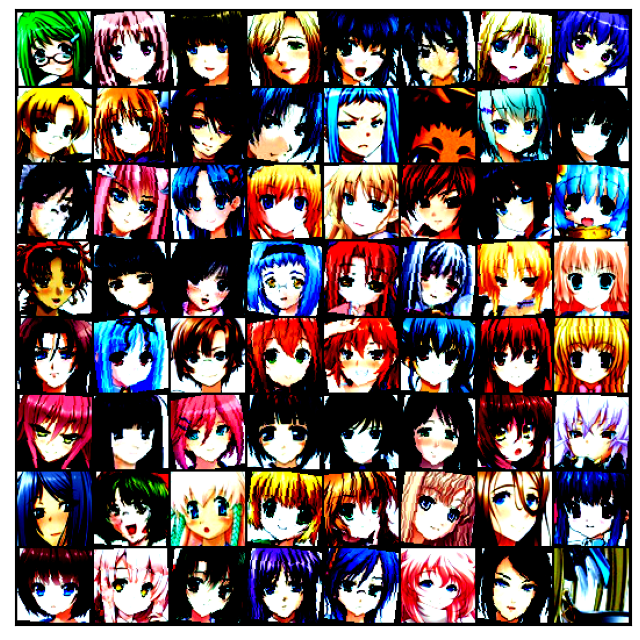

In [100]:
images_batch = next(iter(train_loader))
show_batch(images_batch)

In [101]:
from torch import nn, optim
from torch.autograd import Variable



In [102]:

discriminator_model = nn.Sequential(
    # 64*3*128*128
#     nn.Conv2d(3,16,3,stride=1,padding=1),
#     nn.LeakyReLU(),
#     nn.MaxPool2d(2,2),    
    # 64*16*64*64
    nn.Conv2d(3,32,3,stride=1,padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(2,2),
    # 64*32*32*32
    nn.Conv2d(32,64,3,stride=1,padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(2,2),
    # 64*64*16*16
    nn.Conv2d(64,128,3,stride=1,padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(2,2),
    # 64*254*4*4
#     nn.Conv2d(128,256,3,stride=1,padding=1),
#     nn.LeakyReLU(),
#     nn.MaxPool2d(2,2),
    
    nn.Flatten(),
    
    # 64*256*4*4
    nn.Linear(128*8*8,256),
    nn.ReLU(),    
    nn.Dropout2d(0.2),
    
    nn.Linear(256,1),
    
    nn.Sigmoid()
)



In [103]:
latent_size=256
generator_model = nn.Sequential(
#4096 * 1 * 1
nn.ConvTranspose2d(latent_size,128,4,padding=0),
nn.BatchNorm2d(128),
nn.ReLU(),
    
#2048 * 4 * 4
nn.ConvTranspose2d(128,64,4,padding=1,stride=2),
nn.BatchNorm2d(64),
nn.ReLU(),

#1024 * 8 * 8
nn.ConvTranspose2d(64,32,4,padding=1,stride=2),
nn.BatchNorm2d(32),
nn.ReLU(),

#512 * 16 * 16
nn.ConvTranspose2d(32,16,4,padding=1,stride=2),
nn.BatchNorm2d(16),
nn.ReLU(),

#256 * 32 * 32
nn.ConvTranspose2d(16,3,4,padding=1,stride=2),

#128 * 64 * 64
# nn.ConvTranspose2d(8,3,4,padding=1,stride=2),

#128 * 128 * 128
# nn.ConvTranspose2d(64,3,4,padding=1,stride=2),
    
nn.Tanh()
)

In [104]:
# os.remove('/kaggle/working/discriminator_model.pth')
discriminator_model_path=input_path+'discriminator_model.pth'
if os.path.exists(discriminator_model_path):
    print('loading discriminator model')
    discriminator_model_state = torch.load(discriminator_model_path)
#     print(discriminator_model_state)
    discriminator_model.load_state_dict(torch.load(discriminator_model_path))
    
generator_model_path=input_path+'generator_model.pth'
if os.path.exists(generator_model_path):
    print('loading generator model')
    generator_model_state = torch.load(generator_model_path)
    generator_model.load_state_dict(generator_model_state)
    


loading discriminator model


torch.Size([64, 3, 64, 64])


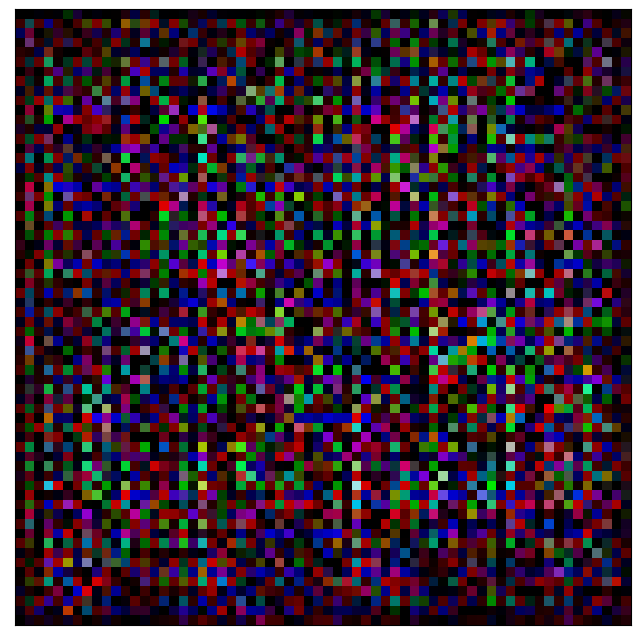

In [105]:
random_vector = torch.rand(batch_size,latent_size,1,1)
fake_images = generator_model(random_vector)
print(fake_images.size())
show_batch(fake_images)

In [106]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('assigning model to gpu')
    discriminator_model.cuda()
    generator_model.cuda()

def to_device(tensor):
    if train_on_gpu:
        return tensor.cuda()
    return tensor.cpu()        
    

assigning model to gpu


In [107]:
def discriminator_train_step(model, images, labels ,criterion,optimizer):
    print('training step')
    model.train()
    train_loss=0.0
    #clear the gradient    
    optimizer.zero_grad()
    # Forward pass, then backward pass, then update weights
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    train_loss=loss.item()* images.size(0)
    return train_loss

def discriminator_validate_step(model, images, labels, criterion):
    print('validation_step')
    model.eval()
    validation_loss=0.0    
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    validation_loss = loss.item()*images.size(0)
    return validation_loss

In [108]:

def train_discriminator_batch(epoch,batch_num,images,discriminator_model, criterion, optimizer,train=True ):
    print('training epoch:{}...training batch:{}'.format(epoch,batch_num))
    func = discriminator_train_step
    
    def get_processor(train,*args):
        if train:
            return lambda: discriminator_train_step(*list(args))
        else:
            func_args = list(args)
            func_args = func_args[0:4]
            return lambda: discriminator_validate_step(*func_args)    
    
    labels = to_device(torch.ones(images.size(0),1))    
    images = to_device(images)
    train_loss = get_processor(train,discriminator_model,images, labels, criterion,optimizer)()
    
    random_vector = to_device(torch.rand(images.size(0),latent_size,1,1))
    fake_images = to_device(generator_model(random_vector))
    fake_labels = to_device(torch.zeros(images.size(0),1))    
    fake_train_loss = get_processor(train,discriminator_model,images, labels, criterion,optimizer)()
    return train_loss,fake_train_loss

def record_epoch_loss(data_loader, loss,fake_loss, loss_list, fake_loss_list,total_loss_list):
    loss /=len(data_loader.dataset)
    fake_loss /= len(train_loader.dataset)   
    loss_list.append(loss)
    fake_loss_list.append(fake_loss)
    total_loss_list.append(loss + fake_loss)

def write_discriminator_training_loss_file(filename, training_losses,fake_train_losses,total_losses,validation_losses,fake_validation_losses,total_validation_losses):
    with open(filename,'w') as loss_file:
        loss_file.writelines(str(training_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(fake_train_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(total_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(validation_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(fake_validation_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(total_validation_losses))
    

def train_discriminator(epochs,optimizer,criterion,discriminator_model,loss_filename):
    training_losses =[]
    fake_train_losses =[]
    validation_losses=[]
    fake_validation_losses=[]
    total_losses =[]
    total_validation_losses=[]    
    min_train_loss = np.Inf
    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0        
        fake_valid_loss=0.0   
        fake_train_loss=0.0
        
        j=1
        for images,_ in train_loader:            
            batch_train_loss, batch_fake_train_loss=train_discriminator_batch(epoch,j,images, discriminator_model,criterion,optimizer)
            train_loss +=batch_train_loss
            fake_train_loss +=batch_fake_train_loss
            j+=1
            
        j=1
        for images ,_ in valid_loader:
            batch_valid_loss, batch_fake_valid_loss = train_discriminator_batch(epoch,j,images, discriminator_model,criterion,optimizer,False)
            valid_loss +=batch_valid_loss
            fake_valid_loss +=batch_fake_valid_loss
            j+=1

        record_epoch_loss(train_loader, train_loss,fake_train_loss,training_losses,fake_train_losses,total_losses)
        record_epoch_loss(valid_loader, valid_loss,fake_valid_loss,validation_losses,fake_validation_losses,total_validation_losses)      

        if (valid_loss+fake_valid_loss) < min_train_loss:
            print('train loss reduced from:{} ==> {}'.format(min_train_loss, valid_loss))
            print('saving current model')
            torch.save(discriminator_model.state_dict(), 'discriminator_model.pth')
            min_train_loss = valid_loss+fake_valid_loss
    write_discriminator_training_loss_file(loss_filename,training_losses,fake_train_losses,total_losses,validation_losses,fake_validation_losses,total_validation_losses)
        
    

In [109]:
criterion= nn.BCELoss()
optimizer=optim.Adagrad(discriminator_model.parameters(),lr=0.001)
epochs=8
discriminator_loss_filename='discriminator_losses.txt'

train_discriminator(epochs,optimizer,criterion,discriminator_model,discriminator_loss_filename )

training epoch:0...training batch:1
training step
training step
training epoch:0...training batch:2
training step
training step
training epoch:0...training batch:3
training step
training step
training epoch:0...training batch:4
training step
training step
training epoch:0...training batch:5
training step
training step
training epoch:0...training batch:6
training step
training step
training epoch:0...training batch:7
training step
training step
training epoch:0...training batch:8
training step
training step
training epoch:0...training batch:9
training step
training step
training epoch:0...training batch:10
training step
training step
training epoch:0...training batch:11
training step
training step
training epoch:0...training batch:12
training step
training step
training epoch:0...training batch:13
training step
training step
training epoch:0...training batch:14
training step
training step
training epoch:0...training batch:15
training step
training step
training epoch:0...training batch:

In [111]:
def parse_loss_file(filename):
    with open(filename,'r') as loss_file:
        lines = loss_file.readlines()
        loss_list_strings=[]
        string=[]
        for line in lines:
            line = line.strip()
            for char in line:
                if char=='[':
                    continue
                if char==']':
        #             print(''.join(string))
                    loss_list_strings.append(''.join(string))
                    string=[]
                    continue
                string.append(char)
#         print(loss_list_strings)
    return loss_list_strings



In [113]:
loss_list_strings=parse_loss_file(input_path+discriminator_loss_filename)
training_losses = list(map(float,loss_list_strings[0].split(',')))
fake_train_losses = list(map(float,loss_list_strings[1].split(',')))
total_losses = list(map(float,loss_list_strings[2].split(',')))
validation_losses = list(map(float,loss_list_strings[3].split(',')))
fake_validation_losses=list(map(float,loss_list_strings[4].split(',')))
epoch_list =range(8)

fake_train_losses

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

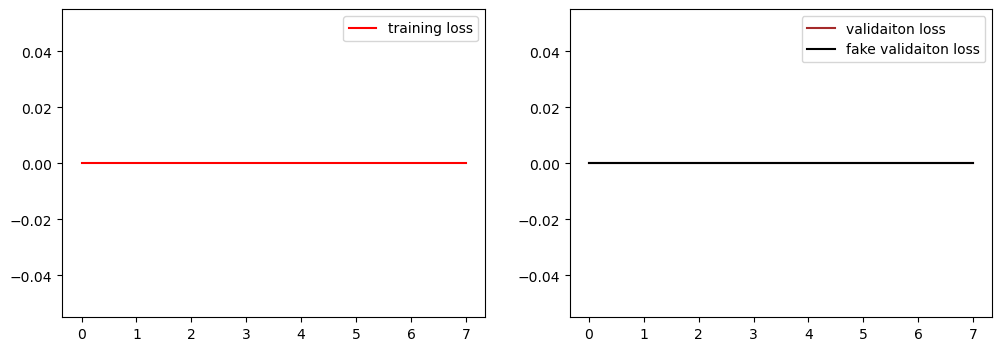

In [114]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
training_loss_plot=ax.plot(epoch_list, training_losses,label='training loss',color='red')
# fake_training_loss_plot=ax.plot(epoch_list, fake_train_losses,label='fake training loss',color='green')
# total_training_loss_plot=ax.plot(epoch_list, total_losses,label='total training loss',color='blue')
validation_losses_plot=ax2.plot(epoch_list, validation_losses,label='validaiton loss',color='brown')
fake_validation_losses_plot=ax2.plot(epoch_list, fake_validation_losses,label='fake validaiton loss',color='black')
ax.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.show()

In [52]:
discriminator_model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.01)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=8192, out_features=256, bias=True)
  (11): ReLU()
  (12): Dropout2d(p=0.2, inplace=False)
  (13): Linear(in_features=256, out_features=1, bias=True)
  (14): Sigmoid()
)

In [38]:
def train_generator_model(batch_size, latent_size,discriminator_model,generator_model,generator_optimizer,criterion):
    random_vector = to_device(torch.rand(batch_size,latent_size,1,1))
    fake_images = to_device(generator_model(random_vector))
    output = discriminator_model(fake_images)
    fake_labels = to_device(torch.ones(batch_size,1))
    
    fake_images,fake_labels = fake_images.cuda(), fake_labels.cuda()
    
    preds = discriminator_model(fake_images)
    loss = criterion(preds,fake_labels)
    
    loss.backward()
    generator_optimizer.step()
    return loss.item() * batch_size    
    
    

In [ ]:
def write_generator_loss_file(filename):
    with open(filename,'w') as loss_file:
        loss_file.writelines(str(generating_losses))
        loss_file.writelines('\n')

epochs = 10000
criterion= nn.BCELoss()
generator_optimizer=optim.Adagrad(generator_model.parameters(),lr=0.02)
epochs_list = []
generating_losses=[]
min_generating_loss=np.Inf
generator_loss_filename='generator_losses.txt'
for epoch in range(epochs):
#     print('generator training epoch:{}'.format(epoch))
    generating_loss =train_generator_model(batch_size,latent_size,discriminator_model,generator_model ,generator_optimizer,criterion)
    generating_losses.append(generating_loss)
    epochs_list.append(epoch)
    if min_generating_loss > generating_loss:
        print('train loss reduced from:{} ==> {} ... saving model'.format(min_generating_loss, generating_loss))
        torch.save(generator_model.state_dict(), 'generator_model.pth')
        min_generating_loss = generating_loss

write_generator_loss_file(generator_loss_filename)

In [ ]:
# loss_list_strings = parse_loss_fle(input_path+generator_loss_filename)
# training_losses = list(map(float,loss_list_strings[0].split(',')))
# epoch_list =range(10000)

# import matplotlib.patches as mpatches
# fig = plt.figure(figsize=(15,4))
# ax = fig.add_subplot(1, 2, 1)
# training_loss_plot=ax.plot(epoch_list, training_losses,label='training loss',color='red')
# ax.legend(loc='upper right')


# plt.show()

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)


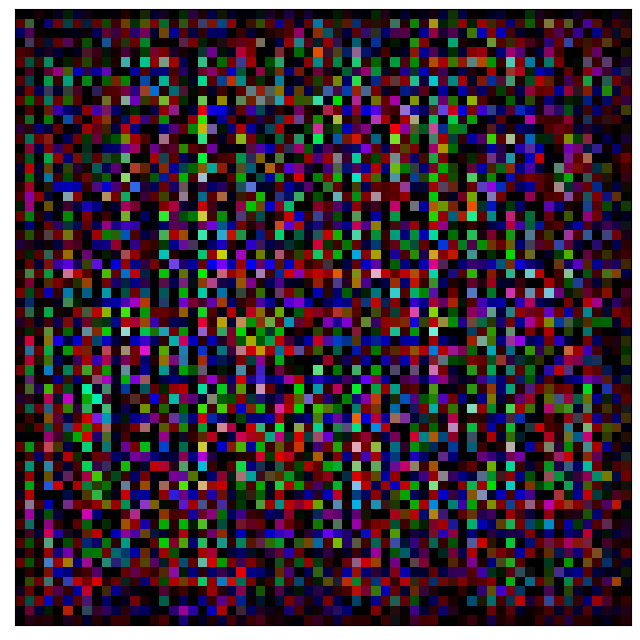

In [115]:
random_vector = to_device(torch.rand(batch_size,latent_size,1,1))
fake_images = to_device(generator_model(random_vector))
fake_labels  = to_device(torch.ones(batch_size,1))
discriminator_model.eval()
output = discriminator_model(fake_images)
print(output)
show_batch(fake_images.cpu())

In [58]:
discriminator_model.eval()
for images,_ in valid_loader:    
    ouput =discriminator_model(to_device(torch.rand(batch_size,3,64,64)))
    print(output)
    break

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
# output = discriminator_model(fake_images)
# output